# Accessing LATISS Data with the Butler

In [ ]:
import os
import numpy as np
import glob
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
from lsst.obs.lsst import Latiss
camera = Latiss().getCamera()
from matplotlib.pyplot import cm
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker

def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('linear', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')


##### First we are going to setup a butler to repository where the LATISS data is ingested on USDF.<br>Here wea re just going to pull some raw images from a specific date and time.

##### You can look up on Rubin TV to check which date, or copy the dataID for a specific exposure.<br>
https://roundtable.lsst.codes/rubintv/summit/auxtel/historical/2023-05-23

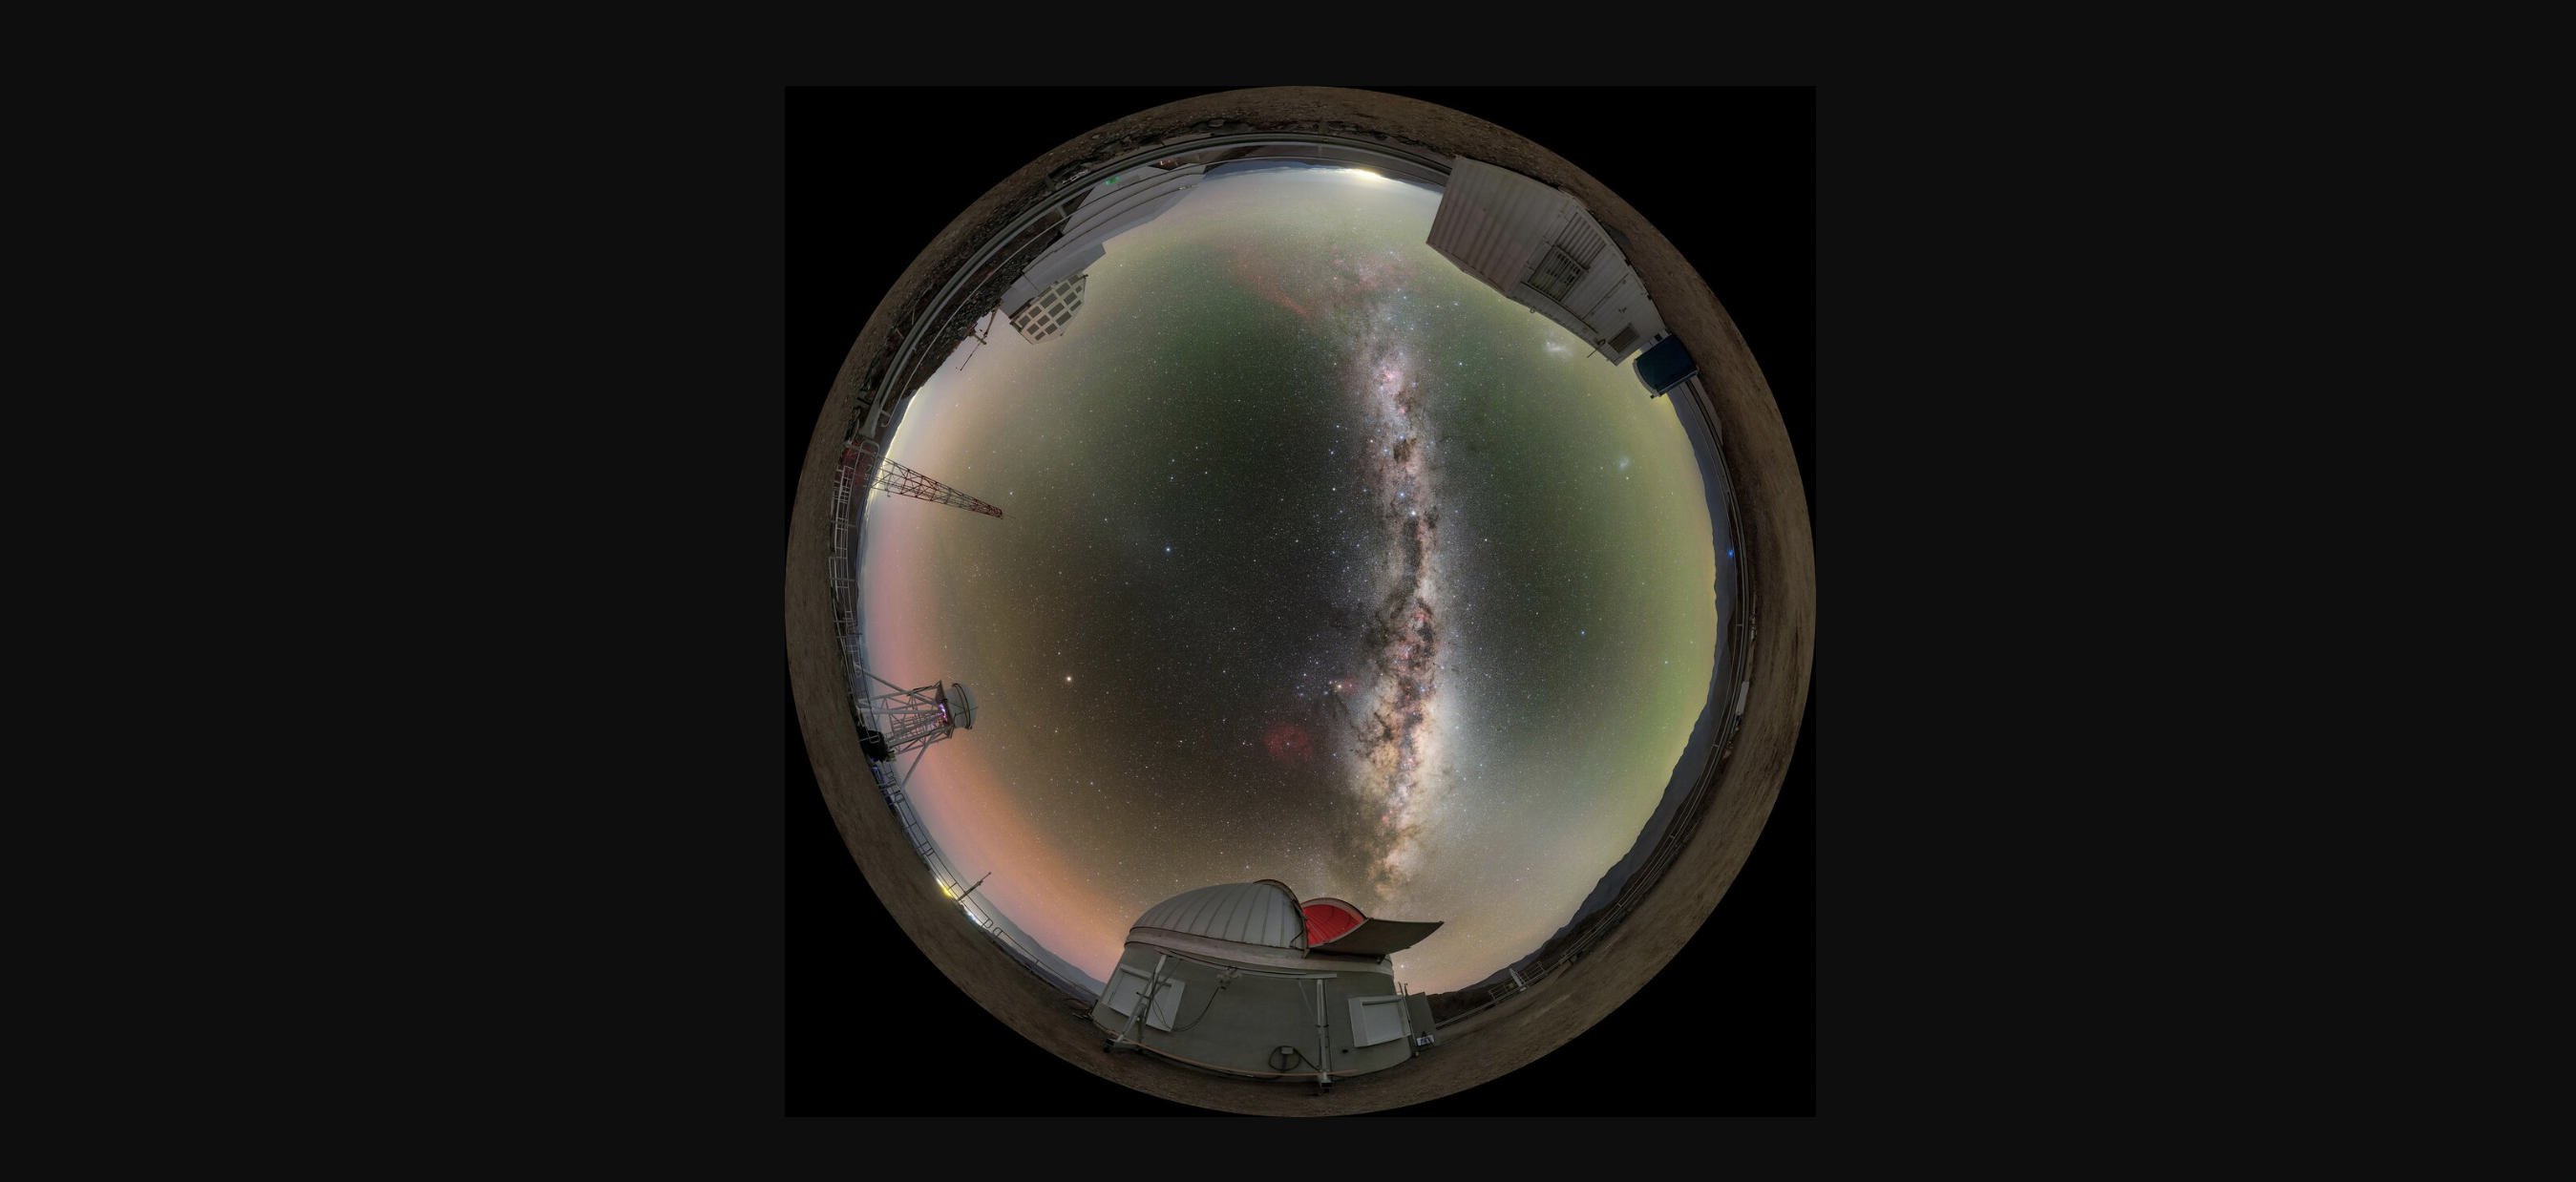

In [ ]:
repo_path = "/repo/embargo"
butler = Butler(repo_path)
registry = butler.registry

for c in registry.queryCollections()[:10]:
    print(c)    

##### We can query the data by date:

In [ ]:
expRecords = list(butler.registry.queryDimensionRecords('exposure'))
#expRecords = [r for r in expRecords if 'science' in r.observation_type and str(r.day_obs)[:4] == '2023' and str(r.day_obs)[4:6] == '05']
expRecords = [r for r in expRecords if 'AUXTEL_PHOTO_IMAGING' in r.science_program 
              and str(r.day_obs)[:4] == '2023' 
              and str(r.day_obs)[4:6] == '05' 
              and str(r.day_obs)[6:] == '23']

print(f"Found {len(expRecords)} records")

idlist = [r.id for r in expRecords]

In [ ]:
print(expRecords[0])

##### Now, we are going to search the raw image collection to pull some of the images from the dates we selected.

In [ ]:
collections = ['LATISS/raw/all', 'LATISS/calib']
#collections = 'u/echarles/calib/bias/run_12781/20210326T180033Z'
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes()[:10]:
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )

In [ ]:
datasetRefs = list(subregistry.queryDatasets(
    datasetType='raw',
    collections=collections,
    instrument='LATISS',
    detector=0,
    where = "exposure.day_obs IN (20230523) \
             AND exposure.observation_type='science' \
             AND exposure.science_program='AUXTEL_PHOTO_IMAGING' "))

print(len(datasetRefs))

In [ ]:
ref = datasetRefs[0]

In [ ]:
ref.dataId

In [ ]:
ref = datasetRefs[0]
raw=butler.get('raw',dataId = ref.dataId, collections=collections)

exptime = raw.getMetadata()['EXPTIME']

display(raw)

In [ ]:
from lsst.ip.isr.isrTask import IsrTask

config = IsrTask.ConfigClass()
config.doDark = True
config.doBias = True
config.doFlat = False
config.doDefect = True
config.doLinearize=False
config.doBrighterFatter=False
config.doApplyGains=False
config.doOverscan=True
# The images tend to have serial structure ("banding"), 
# and this is the best option to remove it.
#config.overscan.fitType: 'MEDIAN_PER_ROW' 
config.overscan.fitType='MEDIAN_PER_ROW'

isrtask = IsrTask(config=config) # default configuration

# Get the calibrations
collections = "LATISS/calib"
bias = butler.get('bias',dataId = {"day_obs": 20230131, "seq_num": 151, "detector": 0},instrument='LATISS', collections=collections)
dark = butler.get('dark',dataId = {"day_obs": 20230523, "seq_num": 45, "detector": 0},instrument='LATISS', collections=collections)
defects = butler.get('defects',dataId = {"day_obs": 20230523, "seq_num": 45, "detector": 0},instrument='LATISS', collections=collections)

postISRStruct = isrtask.run( raw, 
                            camera=camera, 
                            bias=bias, 
                            dark=dark,
                            defects=defects,
                            detectorNum=0)
# Note: the task returns a struct that contains the exposure object
image = postISRStruct.exposure

In [ ]:
display(image)

In [ ]:
image.writeFits("./example_auxtel_image.fits")

In [ ]:
from matplotlib.colors import SymLogNorm
plt.imshow(image.getImage().getArray(), cmap='binary' ,norm=SymLogNorm(10, vmin=-10, vmax=150000, base=10))
plt.colorbar()

In [ ]:
sys.path.append('/home/a/abrought/bin')
from mixcoatl.python.mixcoatl import characterizeSpots

In [ ]:
config = characterizeSpots.CharacterizeSpotsConfig()
findSpotTask = characterizeSpots.CharacterizeSpotsTask(config=config)

In [ ]:
catalog = findSpotTask.run(exposure=image)

In [ ]:
catalog = catalog.sourceCat

In [ ]:
len(catalog)

In [ ]:
display(image)
plt.scatter(catalog['base_SdssCentroid_x'], catalog['base_SdssCentroid_y'], marker="o",facecolors='none', edgecolors='b')

In [ ]:
catalog

In [ ]:
mask = (catalog['base_SdssShape_instFlux'] > 1e3) * (catalog['base_SdssShape_instFlux'] < 1e6) * (catalog['base_SdssCentroid_flag_near_edge'] == False)
_ = plt.hist(catalog['base_SdssShape_instFlux'][mask], bins=100)
plt.yscale('log')

In [ ]:
display(image)
plt.scatter(catalog[mask]['base_SdssCentroid_x'], catalog[mask]['base_SdssCentroid_y'], marker="o",facecolors='none', edgecolors='b')

In [ ]:
_ = plt.hist(catalog['base_SdssShape_xy'], bins=100)
plt.yscale('log')

In [ ]:
plt.imshow(image.getImage().array)
plt.colorbar()

In [ ]:
h = fits.open("/home/a/abrought/auxtel/example_auxtel_image.fits")

In [ ]:
h.info()

In [ ]:
h_cat = fits.open("/home/a/abrought/bin/Piff/examples/572501/D00572501_z_c01_r5473p01_piff.fits")

In [ ]:
h_im = fits.open("/home/a/abrought/bin/Piff/examples/572501/D00572501_z_c01_r3624p01_immasked.fits.fz")

In [ ]:
h_im.info()

In [ ]:
h_cat.info()

In [ ]:
h_cat[1].header